# HW 2. PCA

Бинарная классификация собак и кошек

In [1]:
from dotenv import load_dotenv
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from src.visualization import plot_classification_metrics, visualize_pca_3d

pd.set_option('future.no_silent_downcasting', True)


load_dotenv()

local_data_path = os.getenv('LOCAL_DATA')


### Подготовка данных

Нам даны изображения, приведем их к одному размеру, и вытянем по пикселям в один массив. Так, создадим датафрейм, с которым сможем работать

In [5]:
image_size = (64, 64) # размер изображения
n_images = 500 # объем выборки 

# подготавливаем пути
data_path = os.path.join(local_data_path, "dog-and-cat-classification-dataset", 'PetImages')
data_path = os.path.normpath(data_path)
categories = ['Cat', 'Dog']

# подготавливаем массивы для хранения данных
data = []
labels = []
image_names = []


In [6]:
# считываем и вытягиваем изображения
for category in categories:
    folder_path = os.path.join(data_path, category)
    image_files = os.listdir(folder_path)
    count = 0
    for file in image_files:
        if count >= n_images:
            break
        img_path = os.path.join(folder_path, file)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img)
                img_flat = img_array.flatten()
                data.append(img_flat)
                labels.append(category)
                image_names.append(file)
                count += 1
        except Exception as e:
            print(f"Не удалось обработать {file}: {e}")
            continue


In [7]:
# формируем итоговую таблицу
n_pixels = image_size[0] * image_size[1] * 3
columns = [f'pixel_{i}' for i in range(n_pixels)]

df = pd.DataFrame(data, columns=columns)
df['target'] = labels


### Анализ данных

Проверим на пропуски; посмотрим на разброс в данных. В целом, скорее всего проблем не будет, поскольку мы работаем с пикселями изображения

In [8]:
print(f"Объем выборки: {df.shape}")
df.head()


Объем выборки: (1000, 12289)


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_12279,pixel_12280,pixel_12281,pixel_12282,pixel_12283,pixel_12284,pixel_12285,pixel_12286,pixel_12287,target
0,206,167,90,213,174,97,221,180,101,226,...,2,2,0,2,2,0,2,2,0,Cat
1,39,43,42,44,47,53,43,47,48,36,...,80,62,58,66,49,42,43,31,23,Cat
2,33,39,46,40,45,56,44,49,61,48,...,177,169,13,192,191,2,182,179,7,Cat
3,222,223,218,223,224,218,227,227,226,230,...,218,220,220,216,215,215,215,212,208,Cat
4,138,110,71,147,119,76,107,83,45,117,...,119,104,71,102,90,63,95,85,62,Cat


In [9]:
# приведем таргет к рабочему виду
df['target'] = df['target'].replace({'Cat': 1, 'Dog': 0}).astype(int)


In [10]:
# посмотрим на данные
df.describe()


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_12279,pixel_12280,pixel_12281,pixel_12282,pixel_12283,pixel_12284,pixel_12285,pixel_12286,pixel_12287,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,124.902000,119.979000,111.430000,125.771000,120.515000,111.707000,126.113000,121.051000,112.259000,126.887000,...,125.907000,118.552000,109.725000,125.279000,118.044000,109.399000,124.546000,117.307000,109.239000,0.50000
std,70.038788,70.289438,71.867462,69.547965,69.912356,71.578479,69.298821,69.824895,71.673182,69.062623,...,69.602118,67.773347,69.093294,69.225352,67.705481,68.821728,69.533062,68.136344,69.323514,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,68.750000,62.000000,51.000000,70.750000,63.000000,51.000000,70.000000,64.000000,51.750000,72.000000,...,69.000000,63.000000,55.000000,70.000000,63.000000,54.750000,69.000000,64.750000,52.000000,0.00000
50%,123.000000,115.000000,102.000000,124.500000,115.000000,103.000000,124.500000,118.000000,105.000000,126.000000,...,124.000000,116.000000,101.000000,122.000000,115.500000,101.000000,120.000000,115.000000,101.000000,0.50000
75%,175.250000,170.000000,164.250000,176.250000,171.000000,163.000000,178.250000,172.000000,164.250000,179.000000,...,179.000000,167.250000,158.000000,178.000000,167.000000,157.250000,178.000000,166.000000,155.250000,1.00000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.00000


Логично, что средние, медианы, Q1, Q3, стандартные отклонения находятся примерно в одном диапазоне 

In [11]:
df.isna().sum().sum() # данные не содержат пропусков


0

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # убедимся, что все ок


(800, 12288) (200, 12288) (800,) (200,)


### 1. Логистическая регрессия

Перед обучением нормализуем данные

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Создадим функцию для быстрого и удобного отображения результатов. Так будет легче сравнивать полученные модели между собой

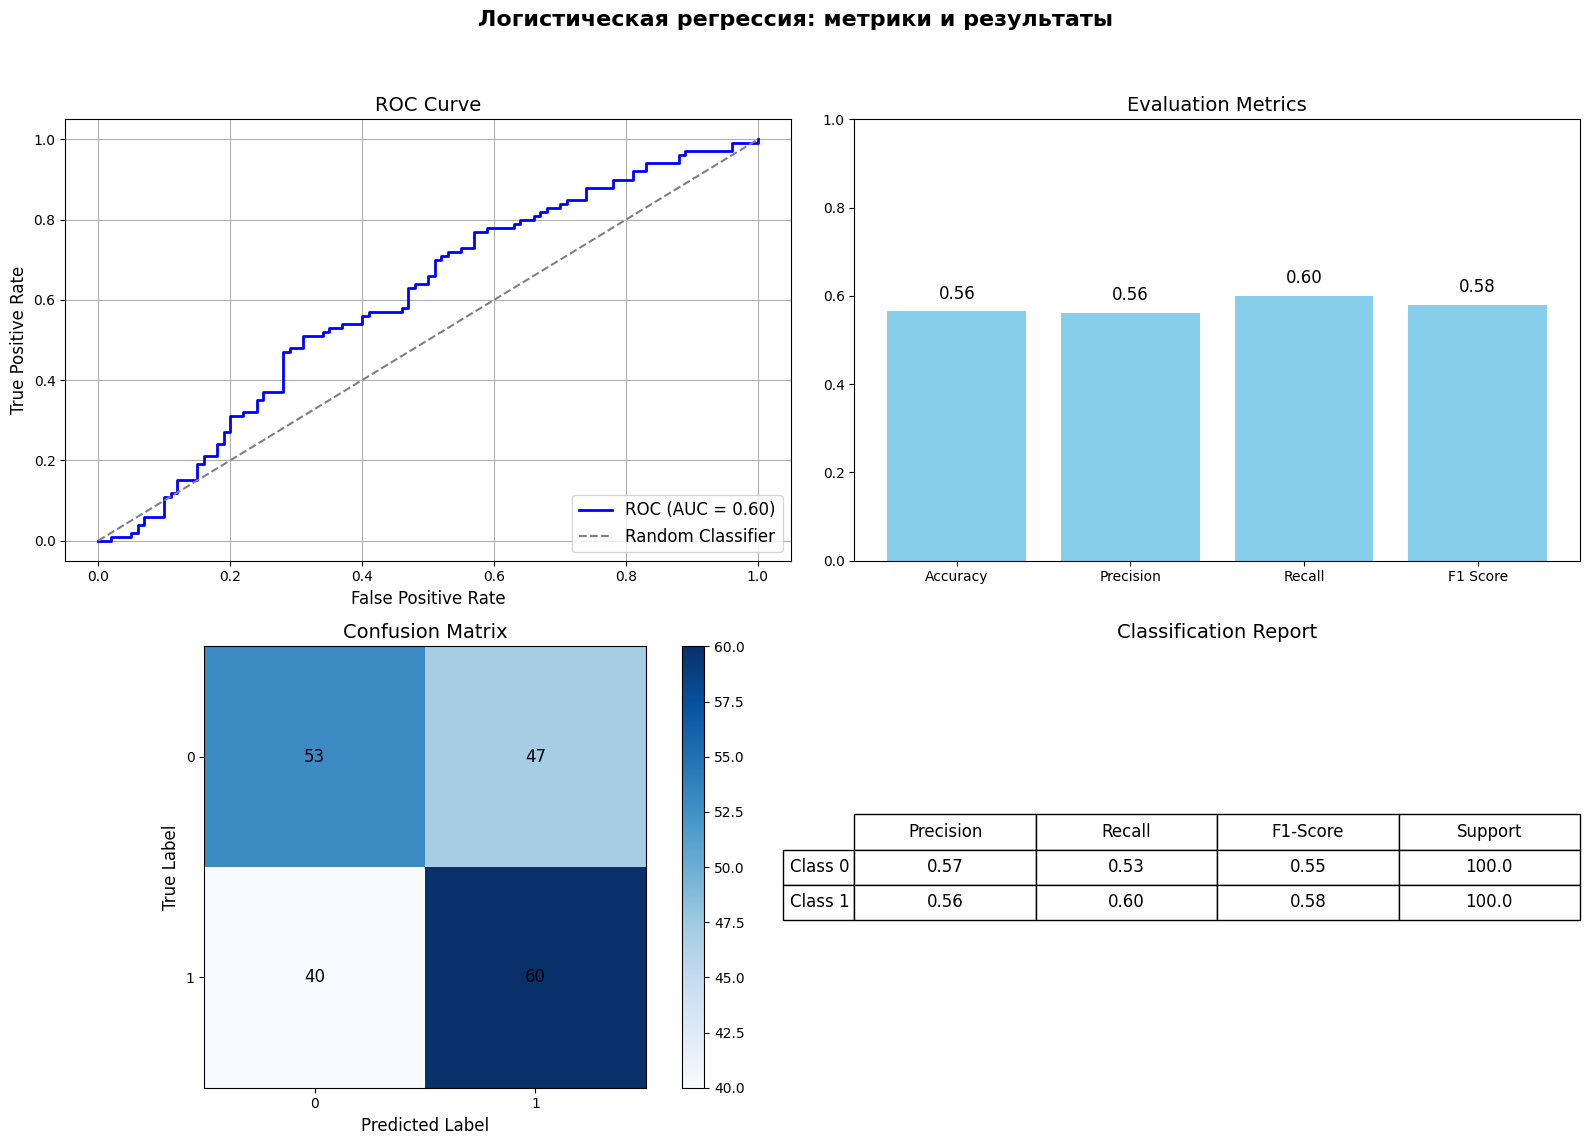

In [15]:
plot_classification_metrics(model, X_test_scaled, y_test, "Логистическая регрессия")

Как видим, наш классификатор близок к случайному. Попробуем обучить другие модели для сравнения

### 2. Random Forest

Рассмотрим Random Forest, поскольку в отличие от других деревянных алгоритмов, используется случайное подмножество признаков в каждом дереве

In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

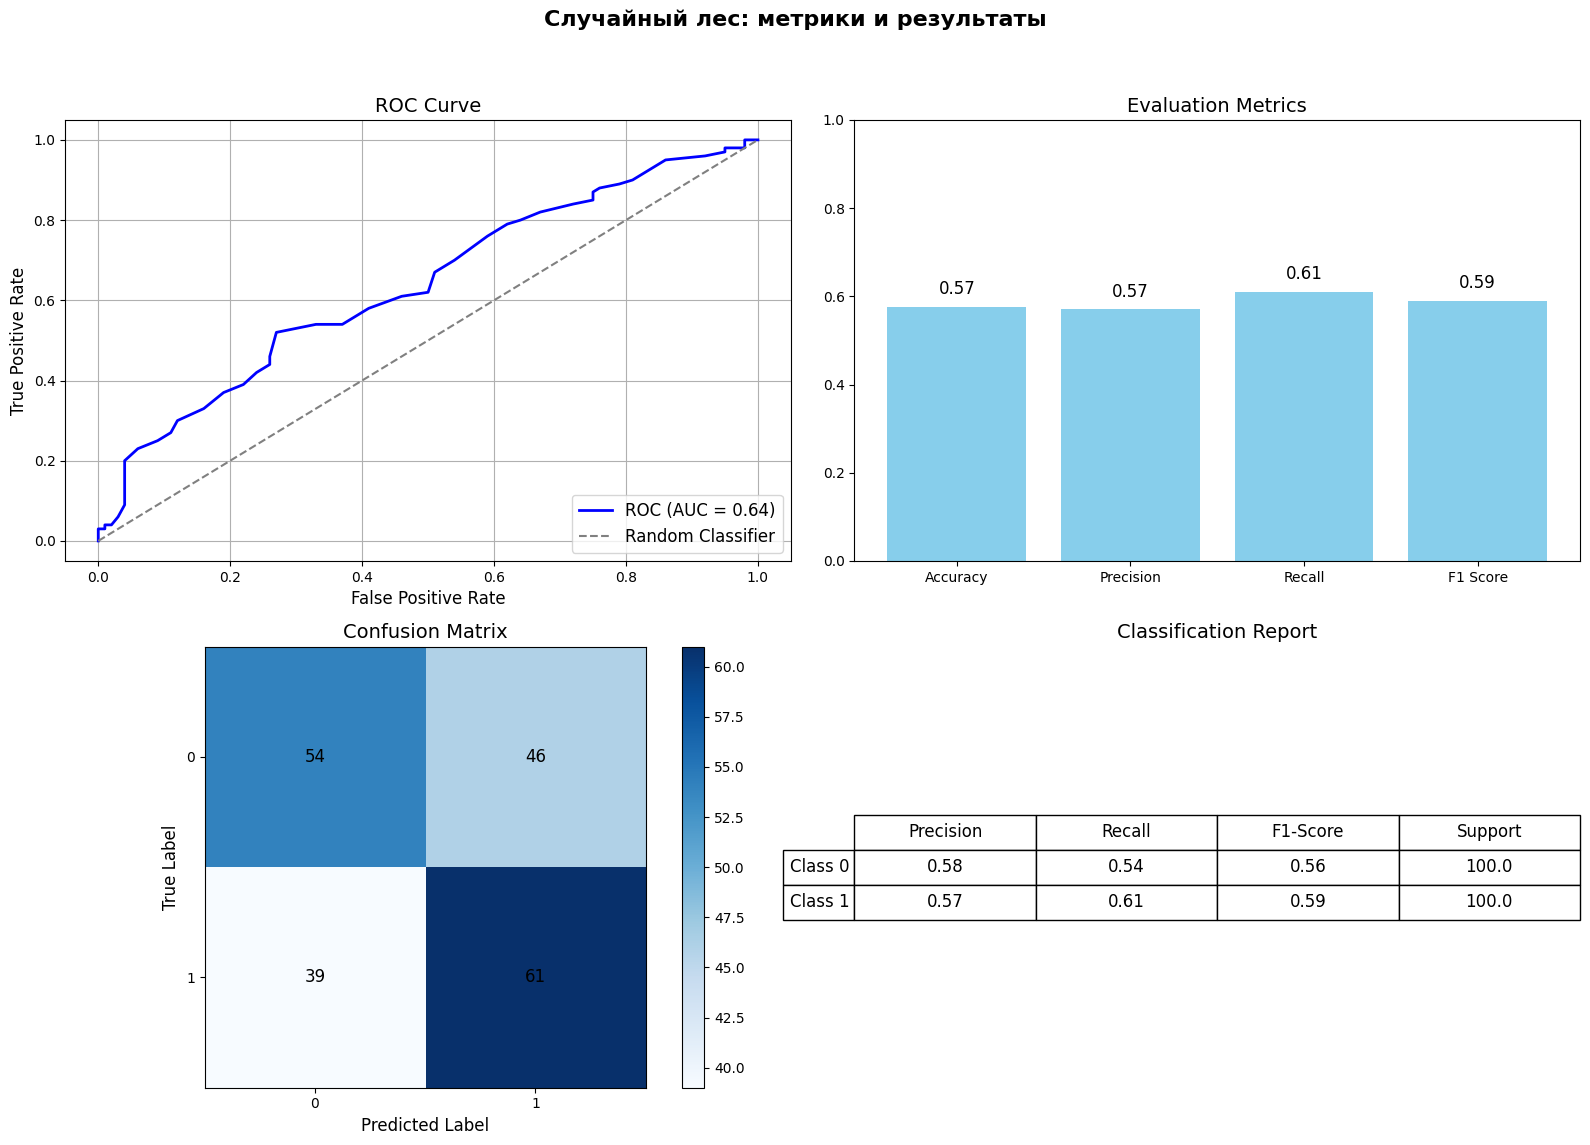

In [17]:
plot_classification_metrics(rf_model, X_test, y_test, "Случайный лес")


Результат получился чуть лучше

## PCA

снизим размерность и проанализируем модели

In [18]:
pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
visualize_pca_3d(X_train_pca, y_train, pca=pca)


Видим, что в случае 3х компонент классы плохо различимы между собой

In [21]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=42)

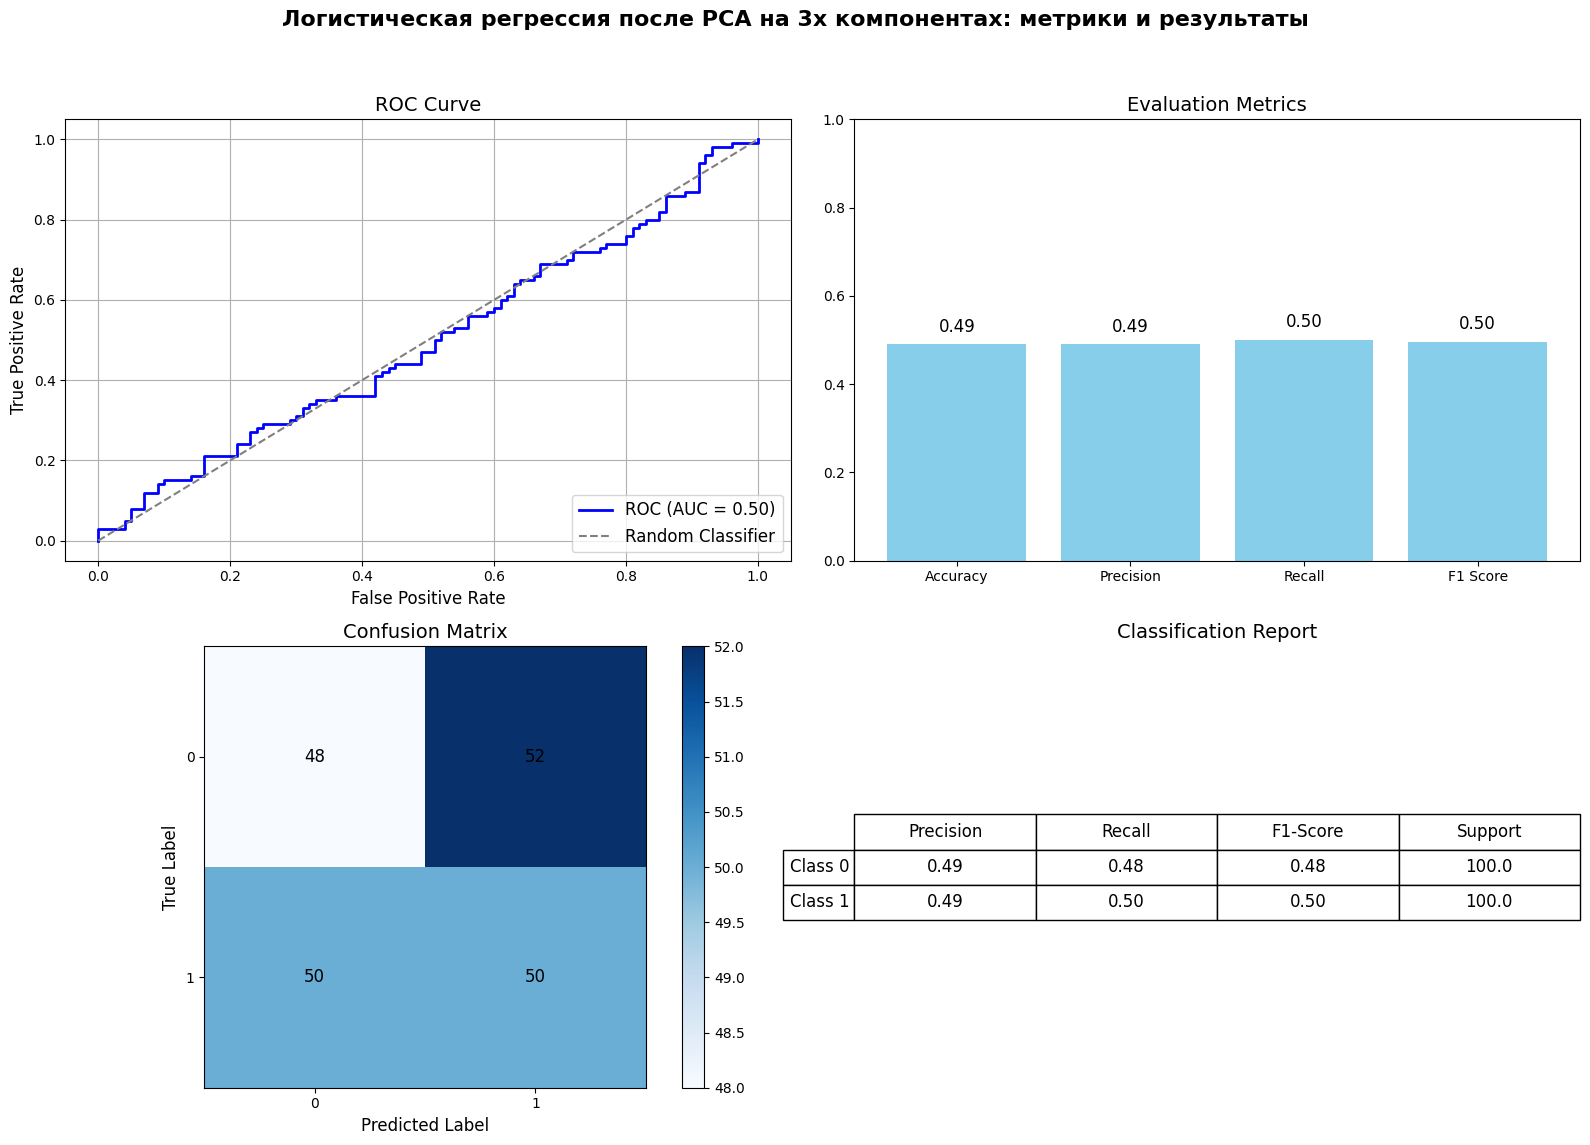

In [22]:
plot_classification_metrics(model, X_test_pca, y_test, "Логистическая регрессия после PCA на 3х компонентах")

Справедливый результат, ведь мы потеряли очень много информации о данных. Попробуем найти оптимальное количество компонент. Для этого выведем график, показывающий, сколько дисперсии объясняет каждая компонента

In [23]:
n_components_to_plot = 500 # выведем только первые 500 компонент
target_var = 90 # посмотрим, сколько компонент необходимо для объяснения 90% дисперсии


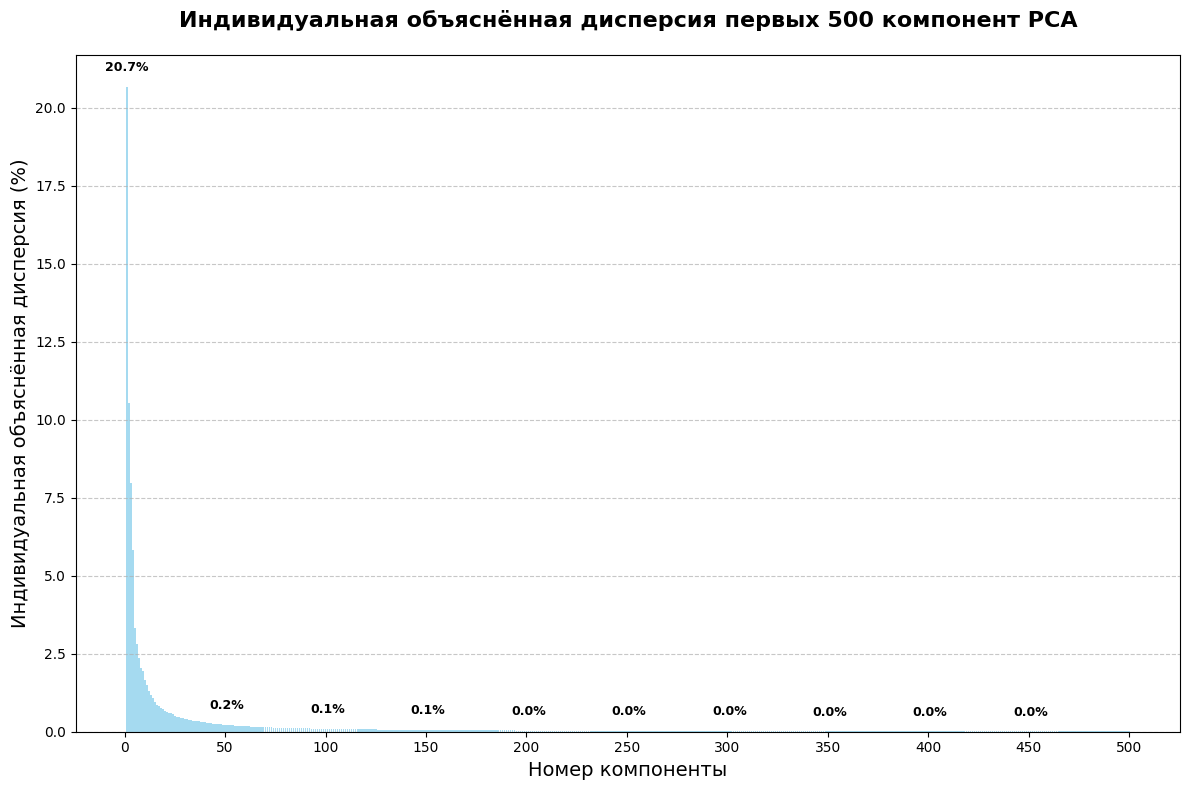

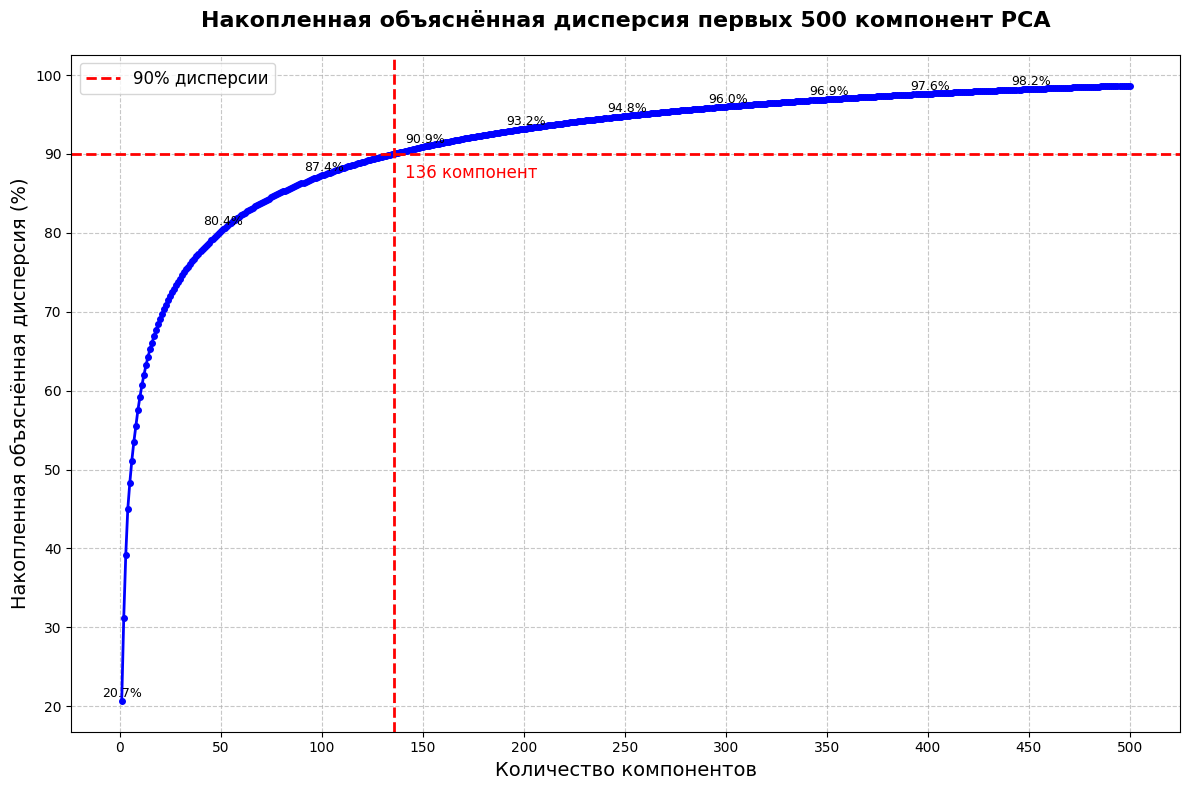

In [35]:
pca_full = PCA()
pca_full.fit(X_train)

# массивы индивидуальной и накопленной объяснённой дисперсии
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

explained_variance = explained_variance[:n_components_to_plot]
cumulative_variance = cumulative_variance[:n_components_to_plot]
components = np.arange(1, n_components_to_plot + 1)

# plt.style.use('ggplot')

# --- График 1: Столбчатая диаграмма индивидуальной объяснённой дисперсии ---
plt.figure(figsize=(12, 8))
bars = plt.bar(components, explained_variance * 100, alpha=0.75, color='skyblue')

# Аннотируем каждый 50-й столбец 
for i, v in enumerate(explained_variance * 100):
    if i % 50 == 0:
        plt.text(components[i], v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold', fontsize=9)

plt.xlabel('Номер компоненты', fontsize=14)
plt.ylabel('Индивидуальная объяснённая дисперсия (%)', fontsize=14)
plt.title('Индивидуальная объяснённая дисперсия первых 500 компонент PCA', fontsize=16, fontweight='bold', pad=20)
plt.xticks(np.arange(0, n_components_to_plot+1, 50))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- График 2: Линейный график накопленной объяснённой дисперсии ---
plt.figure(figsize=(12, 8))
plt.plot(components, cumulative_variance * 100, marker='o', linestyle='-', color='blue', 
         linewidth=2, markersize=4)

# Аннотируем каждый 50-й элемент
for i, cv in enumerate(cumulative_variance * 100):
    if i % 50 == 0:
        plt.text(components[i], cv + 0.5, f"{cv:.1f}%", ha='center', fontsize=9)

plt.xlabel('Количество компонентов', fontsize=14)
plt.ylabel('Накопленная объяснённая дисперсия (%)', fontsize=14)
plt.title('Накопленная объяснённая дисперсия первых 500 компонент PCA', fontsize=16, fontweight='bold', pad=20)
plt.xticks(np.arange(0, n_components_to_plot+1, 50))
plt.grid(axis='both', linestyle='--', alpha=0.7)

if cumulative_variance[-1] * 100 >= target_var:
    comp_idx = np.argmax(cumulative_variance * 100 >= target_var) + 1
    plt.axhline(y=target_var, color='red', linestyle='--', linewidth=2, label='90% дисперсии')
    plt.axvline(x=comp_idx, color='red', linestyle='--', linewidth=2)
    plt.text(comp_idx + 5, target_var - 3, f'{comp_idx} компонент', color='red', fontsize=12)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Видим, что для объяснения 90% дисперсии, необходимо 136 компонент. Для объяснения 95% - уже около 270. Попробуем использовать 136 компонент для обучения.

### 1. Логистическая регрессия с PCA

In [25]:
pca = PCA(n_components=0.9) # объясняем 90% дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)

(800, 136)


In [26]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=42)

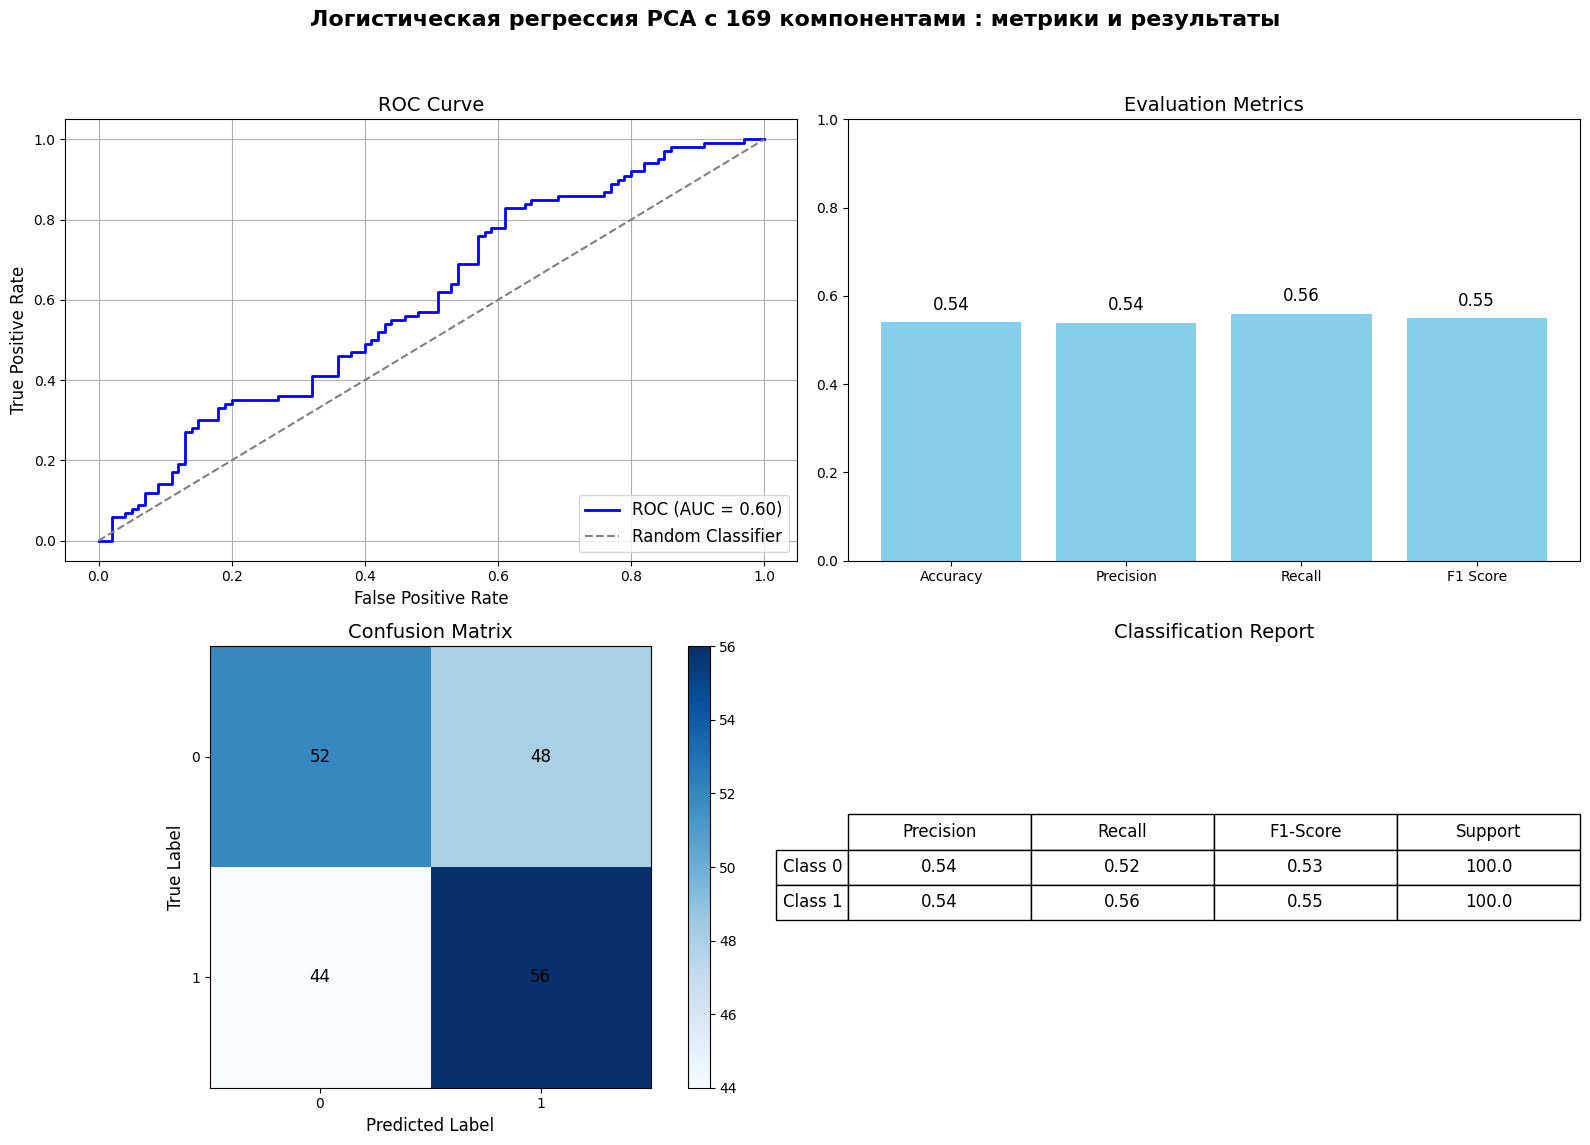

In [27]:
plot_classification_metrics(model, X_test_pca, y_test, "Логистическая регрессия PCA с 169 компонентами ")

Кажется, качество практически не улучшилось :(

### 2. Random Forest

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)


RandomForestClassifier(random_state=42)

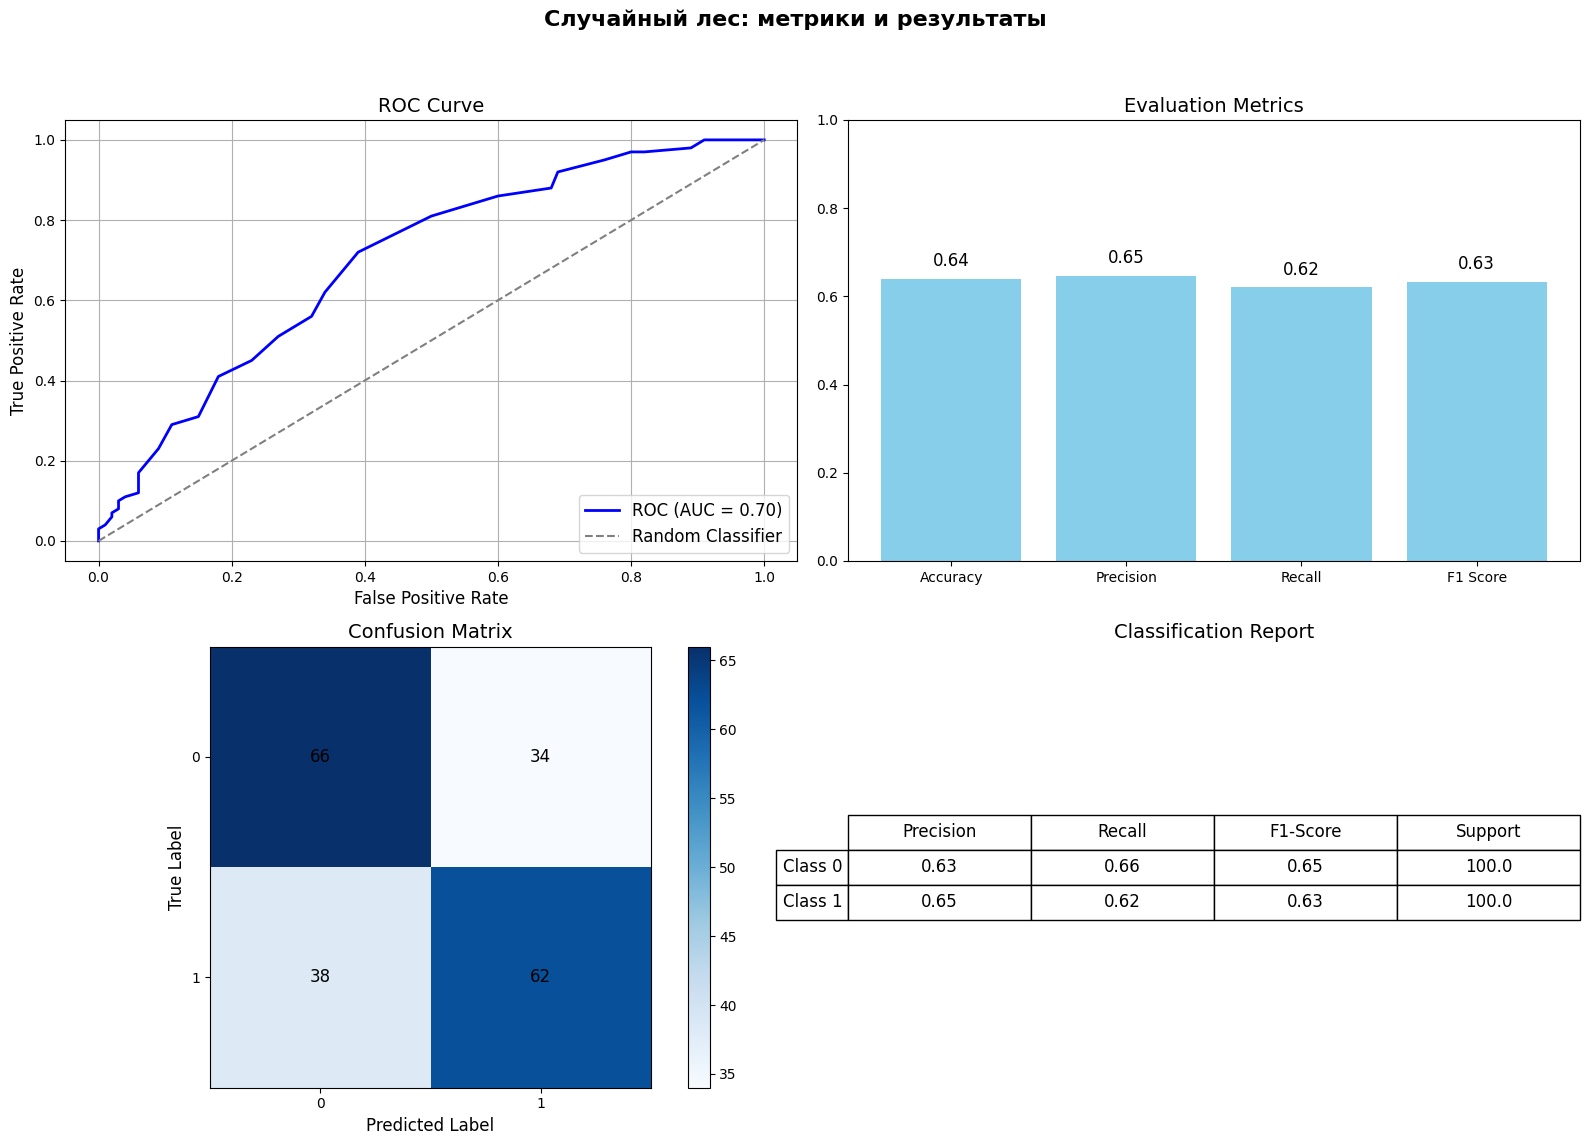

In [29]:
plot_classification_metrics(rf_model, X_test_pca, y_test, "Случайный лес")


А вот случайный лес начал работать заметно лучше после уменьшения пространства признаков

Попробуем взять небольшое число компонент, не ориентируясь на дисперсию

In [32]:
pca = PCA(n_components=25) # объясняем 25 компонент
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)

(800, 25)


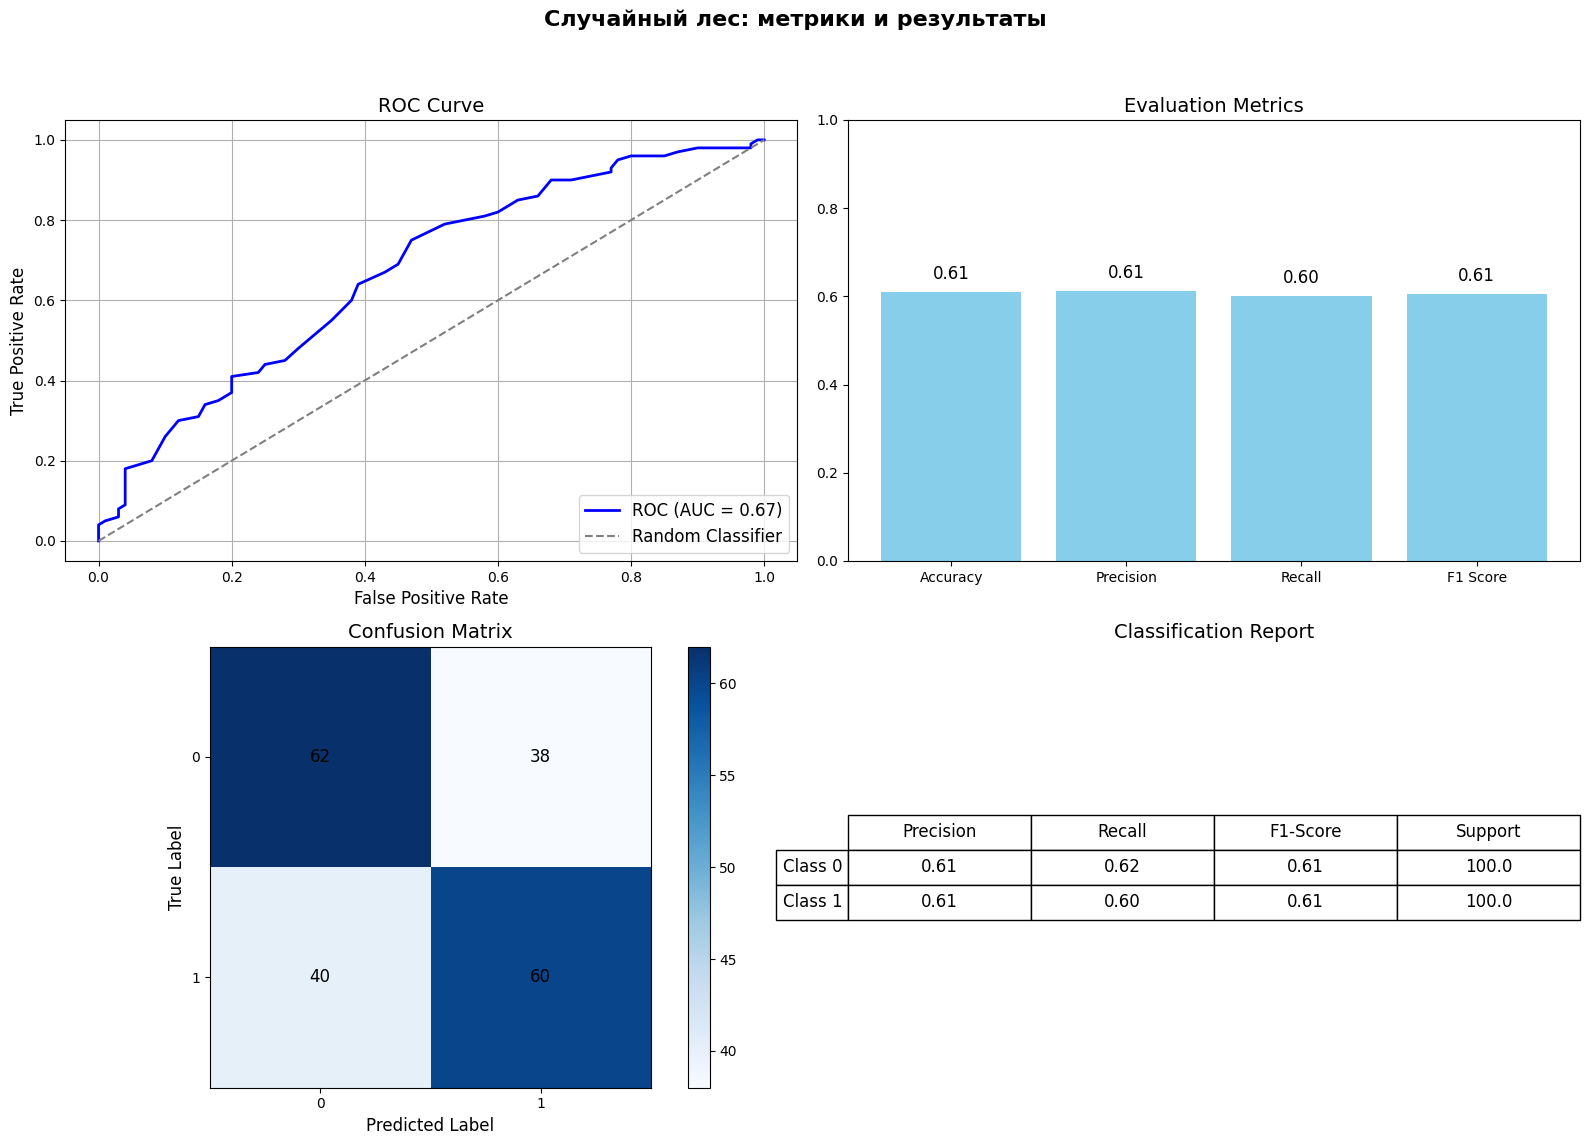

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

plot_classification_metrics(rf_model, X_test_pca, y_test, "Случайный лес")


"Правило локтя" не сработало

Итого, наилучшим результом оказался алгоритм Random Forest, сжатый до 169 компонент. Отобразим первые 10 компонент

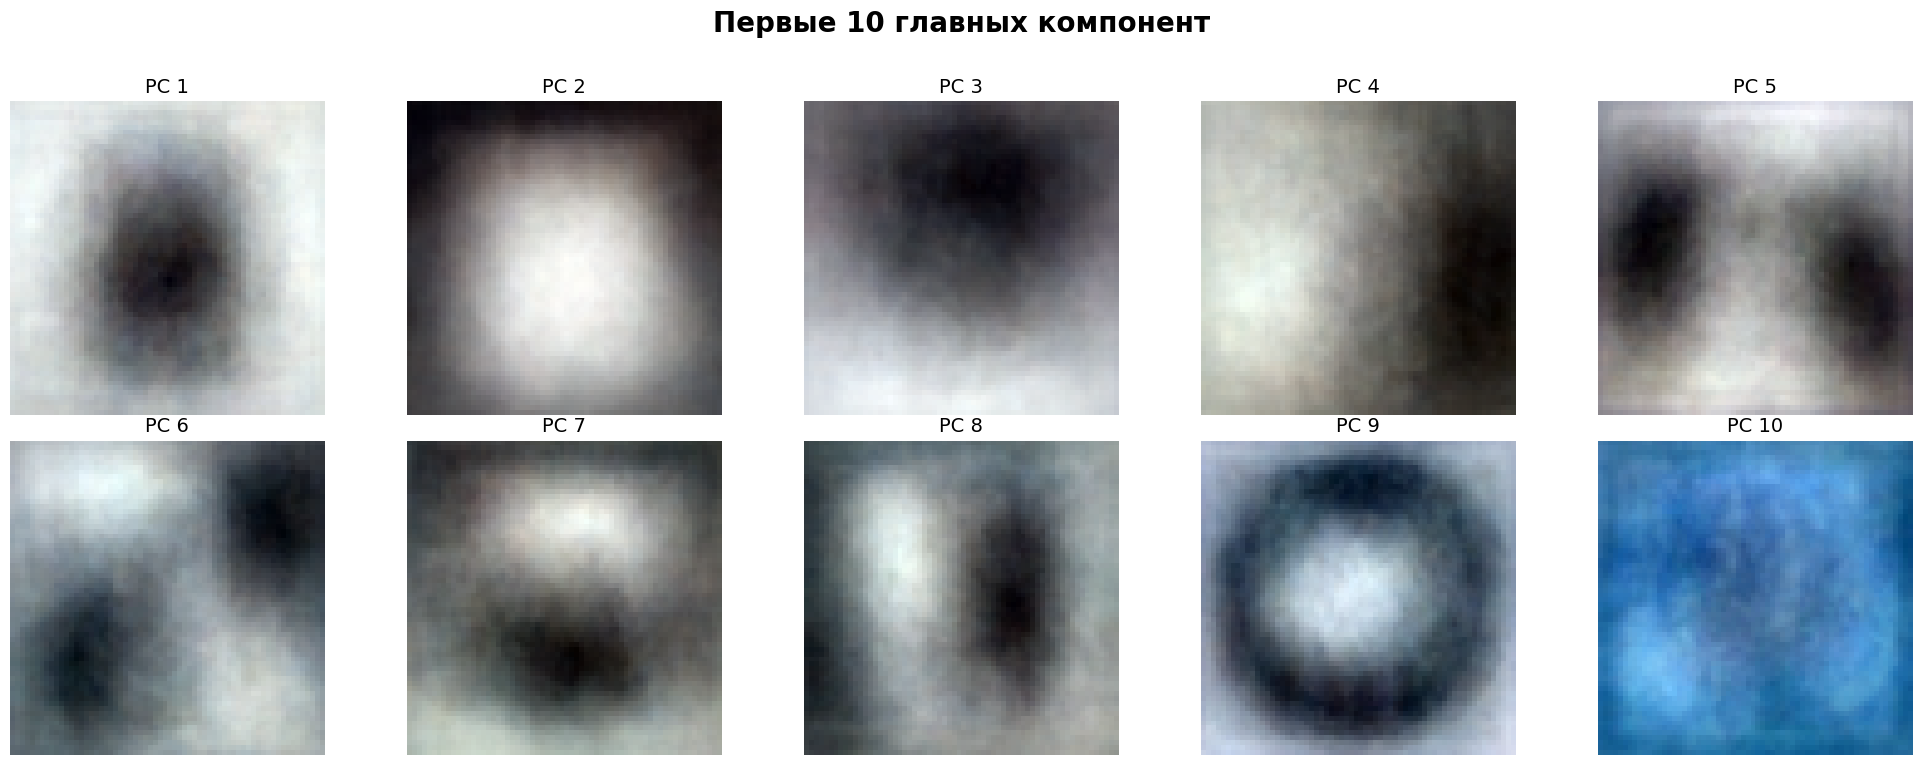

In [ ]:
n_components = min(10, X_train.shape[1])
pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train)

components = pca.components_

image_shape = (64, 64, 3) 

if components.shape[1] == np.prod(image_shape):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    for i in range(n_components):
        comp = components[i]
        # Нормализуем компоненту для корректного отображения
        comp_min, comp_max = comp.min(), comp.max()
        comp_img = (comp - comp_min) / (comp_max - comp_min)
        comp_img = comp_img.reshape(image_shape)
        axes[i].imshow(comp_img)
        axes[i].set_title(f"PC {i+1}", fontsize=14)
        axes[i].axis("off")

    plt.suptitle("Первые 10 главных компонент", fontsize=20, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
else:
    # Если восстановить форму изображения невозможно, строим линейные графики компонент
    plt.figure(figsize=(12, 8))
    for i in range(n_components):
        plt.plot(components[i], label=f"PC {i+1}")
    plt.xlabel("Индекс признака", fontsize=14)
    plt.ylabel("Вклад", fontsize=14)
    plt.title("Первые 10 главных компонент", fontsize=18, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
